## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any iimage into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

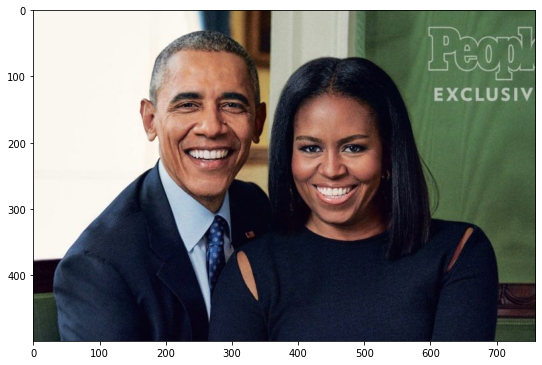

In [2]:
import cv2
# load in color image for face detection
image = cv2.imread('images/obamas.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


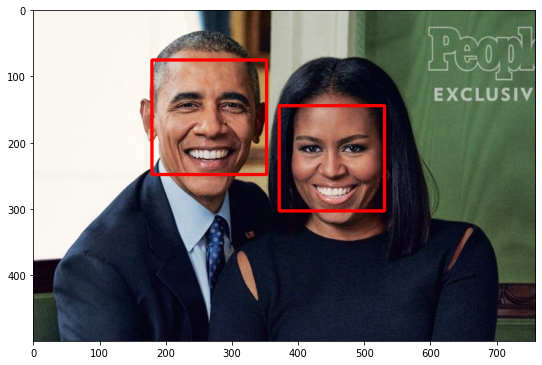

In [3]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [4]:
import torch
from models import Net

net = Net()

# load the best saved model parameters
net.load_state_dict(torch.load('saved_models/keypoints_model_2.pt'))

# print out your net and prepare it for testing
net.eval()

Net(
  (conv_layer1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv_layer2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (pooling_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (dropout4): Dropout(p=0.4, inplace=False)
  (dropout5): Dropout(p=0.5, inplace=False)
  (dropout6): Dropout(p=0.6, inplace=False)
  (fully_connected1): Linear(in_features=36864, out_features=1000, bias=True)
  (fully_connected2): Linear(in_features=1000, out_features=1000, bias=True)
  (fully_connected3): Linear(in_features=1000, out_features=136, bias=True)
)

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### TODO: Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### TODO: Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you'll wrap that Tensor in a Variable() and can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




In [14]:
def show_all_keypoints(image, keypoints):  
    
    plt.figure(figsize=(5,5))
    
    keypoints = keypoints.data.numpy()
    keypoints = keypoints * 60.0 + 96 # Becuase of normalization, keypoints won't be placed if they won't reutrn to values before noramlization 
    keypoints = np.reshape(keypoints, (68, -1)) # reshape to 2 X 68 keypoint for the fase

    image = image.numpy()   
    image = np.transpose(image, (1, 2, 0))  # Convert to numpy image shape (H x W x C)
    image = np.squeeze(image)
    plt.imshow(image, cmap='gray')
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=40, marker='.', c='m')

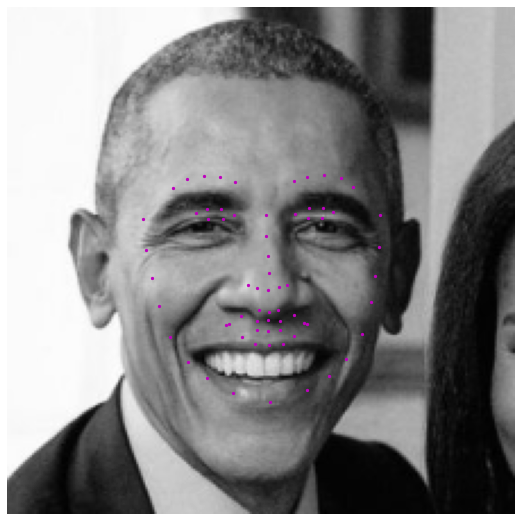

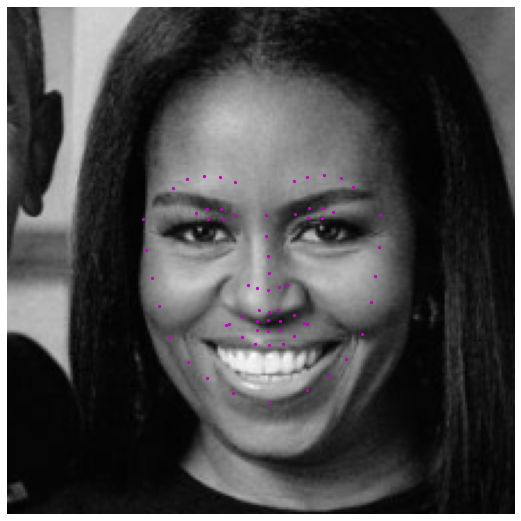

In [31]:
image_copy = np.copy(image)

i = 0

# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
    
    plt.figure(figsize=(20,10))
    ax = plt.subplot(1, len(faces), i+1)
    i += 1
    
    # Select the region of interest that is the face in the image 
    margin = 0.3      
    roi = image_copy[y-int(margin*h):y+h+int(margin*h), x-int(margin*w):x+w+int(margin*w)]
    
    ## TODO: Convert the face region from RGB to grayscale
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi =  roi/255.0
    
    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    output_size = 224
    new_h, new_w = output_size, output_size
    roi = cv2.resize(roi, (new_w, new_h))

    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    roi_reshaped = roi.reshape(roi.shape[0], roi.shape[1], 1)

    roi_transpose = roi_reshaped.transpose((2, 0, 1))
    roi_transpose = roi_transpose.reshape(1, roi_transpose.shape[0], roi_transpose.shape[1], roi_transpose.shape[2])
    roi_tensor = torch.from_numpy(roi_transpose)
    
    dtype = torch.FloatTensor    
    roi_tensor = roi_tensor.type(dtype)  # convert images to FloatTensors

    ## TODO: Make facial keypoint predictions using your loaded, trained network 
    predicted_key_pts = net(roi_tensor) 
    
    # reshape to batch_size x 68 x 2 pts
    predicted_key_pts = predicted_key_pts.view(68, -1)
    
    predicted_key_pts = predicted_key_pts.data
    predicted_key_pts = predicted_key_pts.numpy()
    
    # undo normalization of keypoints  
    predicted_key_pts = predicted_key_pts*50.0+100
    
    ## TODO: Display each detected face and the corresponding keypoints
    plt.imshow(roi, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    plt.axis('off')
        
plt.show()
